In [2]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect
from scipy.ndimage.interpolation import shift
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import newton
import peakutils
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import plotly
plotly.offline.init_notebook_mode()
import plotly.plotly as py
from plotly.offline import iplot,plot
import plotly.graph_objs as go
import time
from multiprocessing import Pool
import multiprocessing
import subprocess
from collections import defaultdict
import multiSQL
import math
from sklearn import linear_model

%matplotlib inline

In [3]:
engine = create_engine('sqlite+pysqlite:///../data/SQL/10C/0075_0001.db')
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
ADC_dfs = [ADCdf]

In [ ]:
parant = '../data/SQL/10C'
fs = [parant+'0075_{:04d}.db'.format(i) for i in range(1)]
fs = ['../data/SQL/10C/0075_0001.db']
ADC_dfs = multiSQL.ParallelDB2(fs,1)

start.... ../data/SQL/10C/0075_0001.db


In [4]:
ADC_dfs[0].head()

,ID,EventID,PadNum,t0,t1,t2,t3,t4,t5,t6,...,t502,t503,t504,t505,t506,t507,t508,t509,t510,t511
0,1,0,-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,-45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,-56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,97,-13.1,-1.1,-0.1,2.9,-2.1,-3.1,-3.1,...,-1.1,-4.1,-7.1,-2.1,-3.1,-6.1,-3.1,-6.1,-0.1,-6.1


In [6]:
engine = create_engine('sqlite+pysqlite:///../data/SQL/10C/ProtoMap.db')
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
print ProtoMapdf.head()

   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4


(-15, 15)

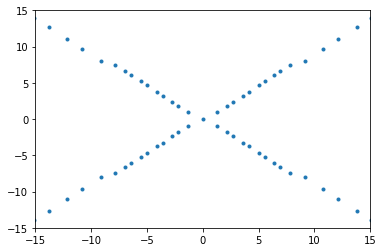

In [16]:
plt.scatter(ProtoMapdf.iloc[:252]['PadX'],ProtoMapdf.iloc[:252]['PadY'],marker='.')
plt.xlim([-15,15])
plt.ylim([-15,15])

In [62]:
tmp = pd.merge(ADCdf,ProtoMapdf,on='PadNum')
tmp = tmp[(tmp['PadX']<10)&(tmp['PadX']>-10)&(tmp['PadY']<10)&(tmp['PadY']>-10)]
tmp = tmp.iloc[:,:-4]
tmp.head()

,ID,EventID,PadNum,t0,t1,t2,t3,t4,t5,t6,...,t502,t503,t504,t505,t506,t507,t508,t509,t510,t511
123392,73,0,65,-13.5,-2.5,1.5,0.5,1.5,4.5,-2.5,...,-1.5,1.5,1.5,1.5,3.5,0.5,-0.5,-1.5,-2.5,5.5
123393,342,1,65,-13.7,-2.7,1.3,2.3,-0.7,-0.7,-0.7,...,0.3,-0.7,-5.7,-1.7,1.3,2.3,4.3,0.3,3.3,5.3
123394,611,2,65,-14.4,-0.4,-3.4,3.6,-1.4,-2.4,-0.4,...,-2.4,-4.4,-5.4,-3.4,-4.4,-8.4,-1.4,-7.4,-8.4,-0.4
123395,880,3,65,-12.6,2.4,6.4,-0.6,3.4,-2.6,5.4,...,-9.6,-10.6,-3.6,-8.6,-2.6,-7.6,-5.6,-5.6,-7.6,-5.6
123396,1149,4,65,-10.2,2.8,-1.2,1.8,2.8,0.8,-0.2,...,-5.2,-2.2,-4.2,-0.2,-7.2,-5.2,-3.2,-5.2,-9.2,-8.2


In [63]:
tmp['PadNum'].unique()

array([ 65,   0, 128,  66, 129,  64,  68, 127,  69,  67, 132, 130,  70,
       131,  73, 133, 136,  71,  74, 134, 137,  72, 135,  10, 198, 200,
         9,  11, 197, 199,   5,   8, 194,   7,   4, 196, 193,   6,   2,
       195,   1,   3, 190, 192, 191])

In [64]:
def Process(ADCdf):
    def rmbackground(Event):
        mesh = Event.iloc[:,3:][Event.iloc[:,3:]>20].sum(axis=0)
        return mesh
    def convolve(event):
        mesh_convol = np.convolve(event.values,([1]*10)[::-1],'same')
        return pd.Series(mesh_convol,index=['t'+str(i) for i in range(512)])

    tmp = pd.merge(ADCdf,ProtoMapdf,on='PadNum')
    tmp = tmp[(tmp['PadX']<10)&(tmp['PadX']>-10)&(tmp['PadY']<10)&(tmp['PadY']>-10)]
    tmp = tmp.iloc[:,:-4]
    
    
    mesh_df = tmp.groupby('EventID').apply(rmbackground)
    convol_df=mesh_df.apply(convolve,axis=1)
    convol_df.reset_index(inplace=True)
    return mesh_df,convol_df

pool = Pool(4)
start_time = time.time()
dfs1 = pool.map(Process,ADC_dfs)
mesh_dfs, convol_dfs = zip(*dfs1)

print time.time()-start_time

25.4437608719


In [20]:
def Process(ADCdf):

    def process(df):

        tmp = df.iloc[:,3:][df.iloc[:,3:]>20].fillna(0)
        ss = tmp.sum(axis=1)
        pos = np.sum(tmp.values*np.arange(512),axis=1)/(ss+1e-6)
        tmp = pos[pos>0.1]
        tmp = tmp.reset_index()
        tmp = pd.merge(tmp,df,left_on='index',right_index=True,how='left')[['PadNum',0]]
        return tmp

    hitdf = ADCdf.groupby(['EventID']).apply(process)
    hitdf = hitdf.reset_index()
    hitdf.columns = ['EventID','d','PadNum','PadZ']
    hitdf = hitdf[['EventID','PadNum','PadZ']];
    
    return hitdf


pool = Pool(5)
start_time = time.time()
hit_dfs = pool.map(Process,ADC_dfs)
print time.time()-start_time
    

32.2687180042


In [7]:
hit_dfs[0].head()

,EventID,PadNum,PadZ
0,1,77,229.198361
1,1,140,214.795159
2,1,68,222.177688
3,1,69,222.622676
4,1,132,220.873852


In [104]:
def Process(hitdf):
    
    tmp1 = pd.merge(hitdf,ProtoMapdf,on='PadNum')
    
    def hough(EID):
        #print "######### Event ",EID
        #tmpdf = pd.merge(hitdf,ProtoMapdf,on='PadNum')
        #print tmpdf
        tmpdf = tmp1[(tmp1['EventID']==EID)]
        tmpdf = tmpdf[np.sqrt(tmpdf['PadX']*tmpdf['PadX']+tmpdf['PadY']*tmpdf['PadY'])>10]

        image = np.zeros([150,550])

        image[(np.sqrt(tmpdf['PadX']*tmpdf['PadX']+tmpdf['PadY']*tmpdf['PadY'])).values.astype(np.int),
              tmpdf['PadZ'].values.astype(np.int)] =255

        #plt.imshow(image, cmap='gray')
        lines = cv2.HoughLines(image.astype(np.uint8),1,np.pi/90,10)
        
        if lines is None:
            #print "Error is here"
            #plt.xlim([0,500])
            #plt.ylim([0,150])
            #plt.savefig('{:03d}'.format(EID)+'.png')
            return

        for rho,theta in lines.reshape(-1,2):
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            #plt.plot((x1,x2),(y1,y2),c=(1,1,1,0.3))
            #cv2.line(image,(x1,y1),(x2,y2),(255,255,255),5)
        #plt.xlim([0,500])
        #plt.ylim([0,150])

        ans = []
        tmp = []

        #print sorted(lines.reshape(-1,2)[:,1])


        for rho,theta in sorted(lines.reshape(-1,2),key=lambda x:x[1]):
            if not tmp:
                tmp.append((rho,theta))
                continue

            if theta-tmp[-1][-1]<0.1:
                tmp.append((rho,theta))
            else:
                ans.append(tmp)
                tmp = [(rho,theta)]

        if tmp:
            ans.append(tmp)

        def IsClose(p,line):
            rho,theta = line
            x0, y0 = rho*np.cos(theta), rho*np.sin(theta) 
            theta1 = (theta+np.pi/2) - int((theta+np.pi/2)/np.pi)*np.pi
            #print theta1,theta
            dist = np.abs(-x*np.sin(theta1) + y*np.cos(theta1)-y0*np.cos(theta1)+x0*np.sin(theta1))
            return dist<3.5


        y = np.sqrt(tmpdf['PadX']*tmpdf['PadX']+tmpdf['PadY']*tmpdf['PadY']).values
        x = tmpdf['PadZ'].values

        #l = np.array([(215.0, 0.54105204), (212.0, 0.57595867)])
        #l = np.array([(236.0, 0.38397244)])
        k,b= None, None
        r = []


        
        for l in ans:
            l = np.array(l)
            #print l.T.mean(axis=1)
            mask = IsClose(np.vstack([x,y]).T,l.T.mean(axis=1))

            for _ in range(10):
                x1,y1 = np.vstack([x,y]).T[mask].T
                #print np.tan(l.T.mean(axis=1)[1]+np.pi/2)

                if len(x1)<1:
                    break

                #k,b = np.polyfit(x1,y1,1)
                #print x1.shape,y1.shape
                k = np.sum((x1-np.mean(x1))*(y1-np.mean(y1)))/np.var(x1)/x1.shape[0]
                #k = np.cov(x1,y1)[0,1]/np.var(x1)/x1.shape[0]*(x1.shape[0]-1)
                b = np.mean(y1) - k*np.mean(x1)

                    
                rho = b/np.sqrt(k*k+1)

                theta = np.arctan(k)+np.pi/2
                
                if np.isnan(rho):
                    return
                
                
                #print rho,theta
                #print l.T.mean(axis=1)
                mask = IsClose(np.vstack([x,y]).T,(rho,theta))

            #plt.scatter(*np.vstack([x,y]).T[mask].T);
            r.append((k,b))

            
            
        return r

    #r = [hough(idx) for idx in range(1900)]

    #print hough(21)
    #print 261.39269983116293/(0.91227228648561765)
    #return 
    
    result = defaultdict(list)

    for idx in hitdf['EventID'].unique():
        lines = hough(idx)
        result['EventID'].append(idx)
        #rtmp = []
        for i in range(3):
            try:
                k,b = lines[i]
                result[i].append(-b/k)
                #rtmp.append(-b/k)
            except:
                result[i].append(None)
                #rtmp.append(None)
        print idx#,rtmp

    line_df = pd.DataFrame(result)
    #line_df = line_df.reset_index()
    #line_df.columns = ['EventID',0,1,2]
    return line_df


cv2.setNumThreads(2)
pool = Pool(1)
start_time = time.time()
line_dfs = pool.map(Process,hit_dfs)
print time.time()-start_time
#Process(hit_dfs[0])

1
3
4
5
6
7
8
11
13
14
15
16
17
18
19
20
21
23
25
26
27
28
29
32
33
34
35
36
37
38
39
40
41
42
44
45
46
48
50
51
52
53
54
55
56
57
58
59
60
61
63
64
65
66
67
68
69
70
71
72
73
74
75
76
78
79
80
82
83
85
86
87
88
89
91
93
94
97
98
100
101
102
103
104
105
106
107
108
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
126
127
128
130
133
134
135
136
137
138
139
140
141
142
143
144
145
146
148
149
150
151
152
153
154
155
156
157
159
161
162
163
165
166
167
168
169
170
171
173
174
177
178
179
180
182
185
186
187
189
190
191
192
193
194
195
196
197
199
200
201
202
203
205
206
207
209
210
211
212
213
214
216
217
218
220
221
222
223
224
225
226
228
229
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
258
260
261
262
263
264
265
266
267
268
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
287
288
289
290
291
292
293
294
295
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
32

/afs/crc.nd.edu/user/j/jlai1/.local/lib/python2.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning:

invalid value encountered in double_scalars



1464
1466
1468
1469
1470
1471
1472
1473
1475
1476
1477
1478
1479
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1493
1494
1495
1496
1497
1498
1499
1501
1502
1504
1505
1506
1507
1508
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1529
1530
1531
1532
1534
1535
1536
1539
1540
1541
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1606
1608
1610
1611
1612
1613
1614
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1628
1630
1632
1633
1634
1635
1637
1639
1640
1641
1642
1643
1644
1646
1647
1648
1649
1650
1651
1653
1654
1655
1656
1657
1659
1660
1661
1662
1663
1664
1665
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1680
1682
1684
1685
1687
1688
1691
1694
1695
1697
1698
1699
1700


In [105]:
def Process(convol_df):
    def t0Process(r):
        grad = np.gradient(r.values[1:])
        xs = 10
        ys = -50
        grad_con = grad#np.convolve(grad,([1]*20)[::-1],'same')
        #print grad
        ratio = float(max(grad[xs:]))/max(grad_con)
        grad_con=grad_con*ratio
        #print "hello1"
        idx_gradcon = peakutils.indexes(abs(grad_con[xs:ys]), thres=0.2, min_dist=5)
        #print "hello2"

        idx_gradcon = [x for x,y in zip(idx_gradcon+xs,grad_con[idx_gradcon+xs]) if y < 0]
        #print idx_gradcon
        if not idx_gradcon:
            return
        return idx_gradcon[-1]#sorted(zip(idx_gradcon,grad_con[idx_gradcon]),key=lambda x:x[1])[-1][0]

    
    mask = (convol_df.iloc[:,50:-50].sum(axis=1)>300000)&(convol_df.iloc[:,50:-50].max(axis=1)<100000)
    #convol_df[mask].iloc[1160:1161].T.plot()
    t0_df = convol_df[mask].apply(t0Process, axis=1)
    t0_df = t0_df.to_frame().reset_index()
    t0_df.columns = ['EventID','time0']
    return t0_df


pool = Pool(4)
start_time = time.time()
t0_dfs = pool.map(Process,convol_dfs)
print time.time()-start_time

#Process(convol_dfs[0])

3.27999091148


In [106]:

def Process(idx):
    
    line_df,t0_df = line_dfs[idx],t0_dfs[idx]
    tmp = pd.merge(line_df,t0_df,how='inner',on='EventID')
    tmp1 = tmp[(~tmp[0].isnull())&(~tmp['time0'].isnull())]
    print tmp1.head()
    tmp1 = pd.DataFrame(tmp1)
    tmp1['pos'] = (tmp1['time0']-tmp1[0])*80/1000.0*2.459
    print tmp1.head()

    return tmp1
    #plt.hist((tmp1['time0']-tmp1[0])*80/1000.0*2.459,bins=100)
    #print tmp1[(tmp1['time0']-tmp1[0])<-10].head()
    
pool = Pool(4)
start_time = time.time()
hist_dfs = pool.map(Process,range(1))
print time.time()-start_time    
    
#Process(line_dfs[0], t0_dfs[0])

            0           1   2  EventID  time0
2  145.719658         NaN NaN       16  122.0
3  229.385284         NaN NaN       17  423.0
5  349.861297         NaN NaN       32  365.0
6  193.245161  193.245161 NaN       35  300.0
7  294.201204         NaN NaN       36  345.0
            0           1   2  EventID  time0        pos
2  145.719658         NaN NaN       16  122.0  -4.666131
3  229.385284         NaN NaN       17  423.0  38.087887
5  349.861297         NaN NaN       32  365.0   2.978086
6  193.245161  193.245161 NaN       35  300.0  21.000812
7  294.201204         NaN NaN       36  345.0   9.993139
0.0643210411072


In [103]:
hist_dfs[0].shape

(583, 6)

In [68]:
hist_dfs[0][(~(hist_dfs[0][1]-hist_dfs[0][0]).isnull())].head()

,0,1,2,EventID,time0,pos
6,193.245161,193.245161,NaN,35,300.0,21.000812
9,288.517614,280.917262,NaN,42,436.0,29.012735
11,237.220212,237.220212,NaN,52,240.0,0.546840
20,224.372830,221.319283,NaN,89,293.0,13.500337
27,259.623402,259.623402,268.998612,110,292.0,6.369124


In [113]:
trace = go.Histogram(x=(hist_dfs[0][1]-hist_dfs[0][0]), autobinx=False,xbins=dict(start=-100, end=100, size=0.2))
iplot([trace])
hist_dfs[0][(hist_dfs[0][1]-hist_dfs[0][0]).abs()>5].shape


(27, 6)

In [44]:
t0_dfs[0][t0_dfs[0]['EventID']==89]

,EventID,time0
26,89,293.0


In [32]:
hist_dfs[0][(hist_dfs[0]['pos']<100)&(hist_dfs[0]['pos']>40)]

,0,1,2,EventID,time0,pos
15,237.220212,237.220212,NaN,52,444.0,40.677720
151,190.611382,190.611382,NaN,385,458.0,52.600689
236,221.226956,NaN,NaN,550,429.0,40.873113
379,154.814208,NaN,NaN,786,455.0,59.052549


In [101]:
line_dfs[0].iloc[:20]

,0,1,2,EventID
0,222.674121,220.094782,NaN,1
1,195.999983,195.999983,NaN,3
2,196.000014,196.000014,NaN,4
3,NaN,NaN,NaN,5
4,NaN,NaN,NaN,6
5,NaN,NaN,NaN,7
6,195.999958,195.999958,NaN,8
7,195.999998,195.999998,NaN,11
8,NaN,NaN,NaN,13
9,NaN,NaN,NaN,14


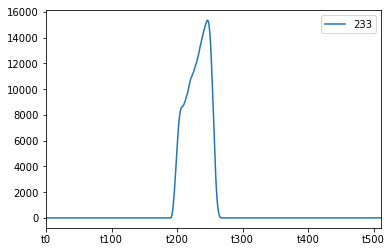

In [52]:
convol_dfs[0][convol_dfs[0]['EventID']==233].iloc[:,1:].T.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d32ed2850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d3143b790>]], dtype=object)

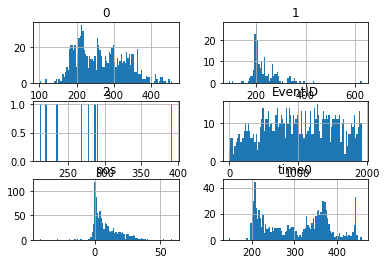

In [24]:
pd.concat(hist_dfs).hist(bins=100)

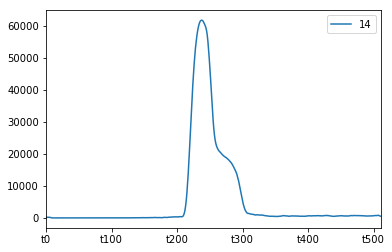

In [91]:
convol_dfs[0][convol_dfs[0]['EventID']==14].iloc[:,1:].T.plot()

In [95]:
ADCdf = ADC_dfs[0]

EID=14
adc_map_df = pd.merge(ADCdf[ADCdf['EventID']==EID],ProtoMapdf,on='PadNum')
#print adc_map_df.head(),adc_map_df.shape
hitdf1 = pd.melt(adc_map_df,id_vars=['EventID','PadNum','PadX','PadY'],value_vars=['t'+str(i) for i in range(512)])
#print hitdf.head(),hitdf.shape
hitdf1.columns = ['EventID','PadNum','PadX','PadY','PadZ','C']
hitdf1['PadZ']=hitdf1['PadZ'].str.lstrip('t').astype(np.int)
tmpdf = hitdf1[hitdf1['C']>20]


trace1 = go.Scatter3d(
    x=tmpdf['PadX'],
    y=tmpdf['PadY'],
    z=tmpdf['PadZ'],#*80/1000.0*2.459,
    mode='markers',
    marker=dict(
        size=3,
        color='b',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)
iplot([trace1], filename='basic histogram')

trace1 = go.Scatter(
    y=np.sqrt(tmpdf['PadX']*tmpdf['PadX']+tmpdf['PadY']*tmpdf['PadY']),
    x=tmpdf['PadZ'],#*80/1000.0*2.459,
    mode='markers',
    marker=dict(
        size=3,
        color='b',                # set color to an array/list of desired values
        opacity=0.8
    )
)
iplot([trace1], filename='basic histogram')

In [21]:
x,y = np.array([1,2,3]),np.array([3.1,5,6.8])
k = np.cov(x,y)[0,1]/np.var(x)/x.shape[0]*(x.shape[0]-1)
b = np.mean(y) - k*np.mean(x)
print k,b
print np.sum((x-np.mean(x))*(y-np.mean(y)))/np.var(x)/x.shape[0]

1.85 1.26666666667
1.85


In [38]:
(511-240)*80.0/1000.0*2.459

53.31112

In [30]:
np.var(x)

0.66666666666666663

In [32]:
np.sum(np.power(x-np.mean(x),2))

2.0

In [34]:
np.var(x)*3

2.0

In [50]:
x.shape

(3,)

In [19]:
x,y = np.random.rand(1000000000),np.random.rand(1000000000)

In [20]:
np.sum((x-np.mean(x))*(y-np.mean(y)))/np.var(x)/x.shape[0]

423.1058896868509

In [12]:
h = pd.read_csv('Position.csv',header=None)
trace = go.Histogram(x =h[1],    autobinx=False,
    xbins=dict(
        start=-10,
        end=50,
        size=0.1
    ))
iplot([trace])